# Final Project

## Exploratory Data Analysis

The exploratory data analysis is something that you should do before building your recommender system. It is a good way to understand your data and to get insights about it. The main goal of such a procedure is to get answers to several questions about your data, these answers should be the numerical justification for all your choices in the following steps, in particular for the feature engineering and the model selection.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

For this data analysis, we will focus on the interaction data, i.e., the data that contains the user-item interactions. If you make the choice to use the other data available, you should repeat the same kind of analysis on the other data as well.

In [60]:
interactions = pd.read_csv("data_final_project/KuaiRec/data/small_matrix.csv")

interactions.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364


### Questions about the data
- How many unique users and items are there in the data? Results are coherent with the Table 1 of the paper

In [21]:
users_len = interactions["user_id"].nunique()
videos_len = interactions["video_id"].nunique()

print(f"Users len: {users_len}")
print(f"Videos len: {videos_len}")

Users len: 1411
Videos len: 3327


- What are the data types?

In [19]:
print(interactions.dtypes)

user_id             int64
video_id            int64
play_duration       int64
video_duration      int64
time               object
date              float64
timestamp         float64
watch_ratio       float64
dtype: object


To specify what are each column:

| Field Name     | Description                                      | Type     |
|----------------|--------------------------------------------------|----------|
| user_id        | The ID of the user.                              | int64    |
| video_id       | The ID of the viewed video.                      | int64    |
| play_duration  | Time of video viewing of this interaction (ms).  | int64    |
| video_duration | Time of this video (ms).                         | int64    |
| time           | Human-readable date for this interaction.        | str      |
| date           | Date of this interaction.                        | int64    |
| timestamp      | Unix timestamp.                                  | float64  |
| watch_ratio    | The video watching ratio                         | float64  |

- Are there timestamps, and if so, what is their range?

In [25]:
interactions["time"] = pd.to_datetime(interactions["time"])

print(f"Timestamp range: {interactions["time"].min()} to {interactions["time"].max()}")

Timestamp range: 2020-07-04 02:23:26.060000 to 2020-09-05 23:57:23.683000


- How many interactions are there in the data? Per user? Per item?

In [34]:
total_interactions = len(interactions)
print(f"Total interactions number {total_interactions}")

interactions_per_user = interactions.groupby("user_id").size()
print(f"Mean interactions per user: {interactions_per_user.mean()}")

interactions_per_item = interactions.groupby("video_id").size()
print(f"Mean interactions per item: {interactions_per_item.mean()}")

Total interactions number 4676570
Mean interactions per user: 3314.3656980864635
Mean interactions per item: 1405.6417192666065


Both mean interactions per user and per item are very close of the number of user/item: 3314 for 3327 videos and 1406 for 1411 users. This shows the high density of the small_matrix dataset.<br>
Let's to to calculate the **density** of the small_matrix dataset with the following formula:

$$
\text{Density} = \frac{\text{Number of observed user-item interactions}}{\text{Number of unique users} \times \text{Number of unique items}}
$$

In [40]:
interactions_density = total_interactions / (users_len * videos_len)
print(f"small_matrix dataset density: {interactions_density * 100}%")

small_matrix dataset density: 99.62024941648522%


We get exactly the density of small_matrix described by the paper on Table 1

 - What is the distribution of the interactions? Per user? Per item?

###  Data Quality & Missing Values

- Checking for missing value: a lot of time/date/timestamps are missing from the dataset, but other categories don't present any missing values.

In [43]:
interactions.isnull().sum()

user_id                0
video_id               0
play_duration          0
video_duration         0
time              181992
date              181992
timestamp         181992
watch_ratio            0
dtype: int64

- Checking for duplicates: no found (TODO: do something smarter, for example comparing only user_id and video_id)

In [46]:
interactions.duplicated().sum()

0

- Checking for negative or zero durations and negative timestamps: no found

In [57]:
print((interactions["play_duration"] < 0).sum() + (interactions["video_duration"] <= 0).sum())
print((interactions["timestamp"] < 0).sum())

0
0


- Checking for anomalies in watch ratio: there are some rare very high and very low watch ratio values, we would need to handle this.

In [62]:
print(f"Watch ratio range: {interactions["watch_ratio"].min()} to {interactions["watch_ratio"].max()}")

# Exclude zero values for min calculation
non_zero_watch_ratios = interactions[interactions['watch_ratio'] > 0]['watch_ratio']
print(f"Watch ratio range: {non_zero_watch_ratios.min()} to {interactions["watch_ratio"].max()}")

Watch ratio range: 0.0 to 571.5214280603849
Watch ratio range: 7.208038404428618e-06 to 571.5214280603849


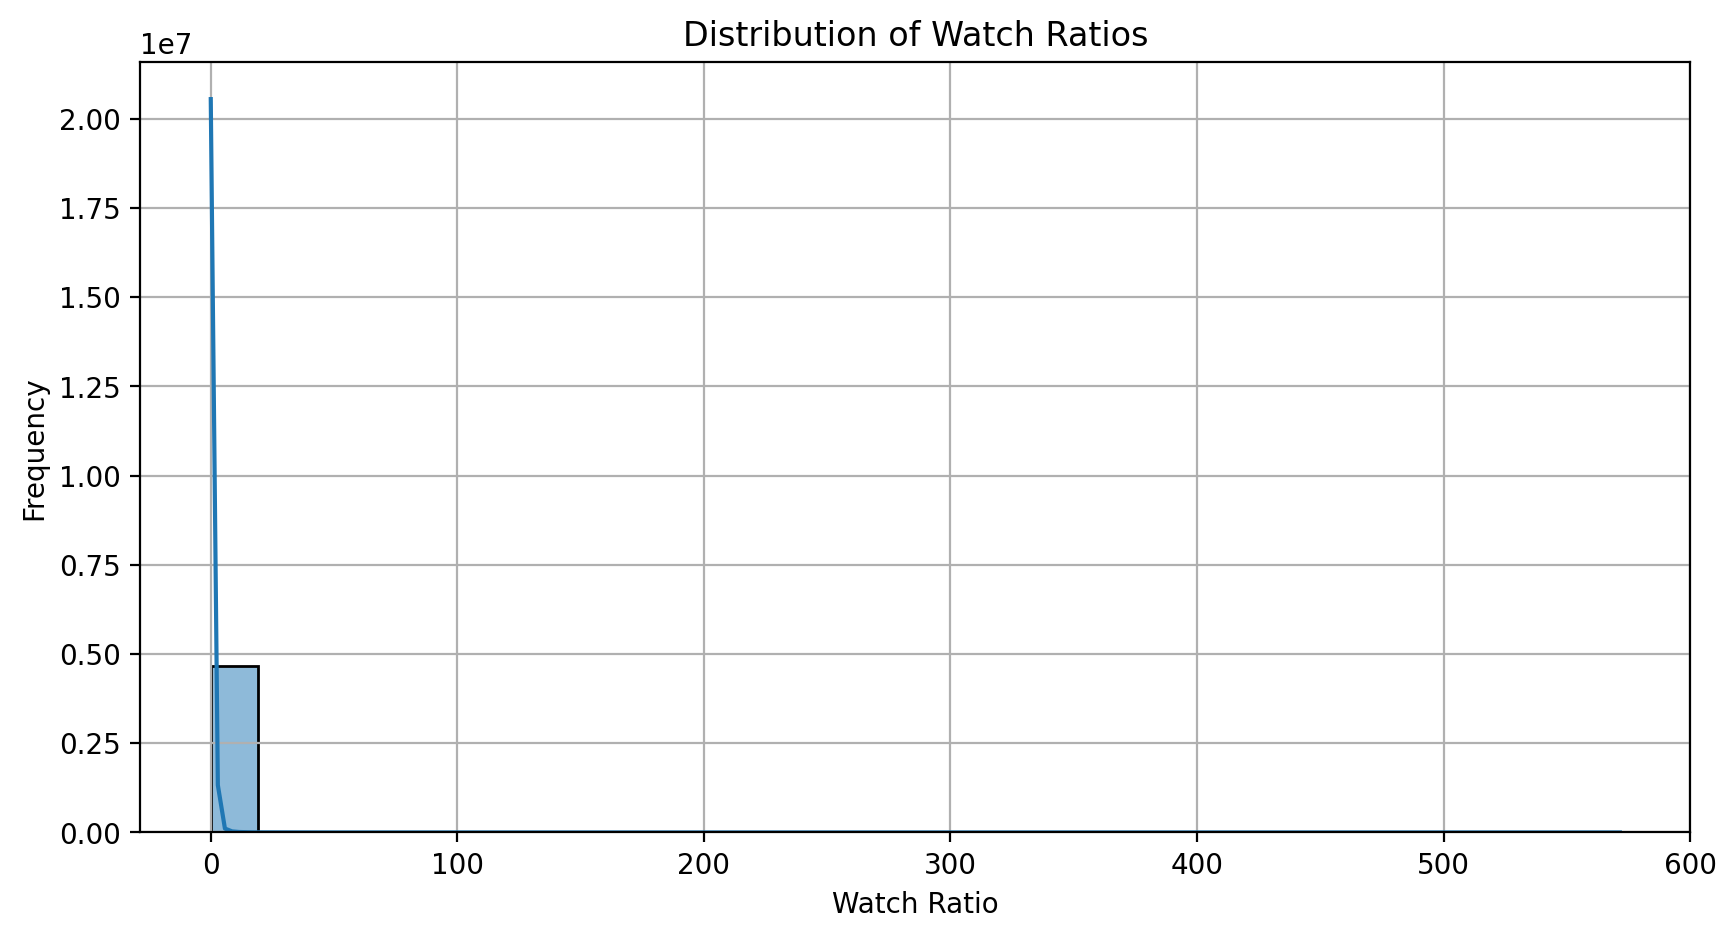

In [64]:
plt.figure(figsize=(10, 5))
sns.histplot(interactions["watch_ratio"], bins=30, kde=True)
plt.title("Distribution of Watch Ratios")
plt.xlabel("Watch Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

- Additionnal data checks:

In [72]:
# Average watch ratio per user
avg_watch_ratio_user = interactions.groupby("user_id")["watch_ratio"].mean()
print(f"Average watch ratio per user: {avg_watch_ratio_user.mean()}")

# Average watch ratio per video
avg_watch_ratio_video = interactions.groupby("video_id")["watch_ratio"].mean()
print(f"Average watch ratio per video: {avg_watch_ratio_video.mean()}")

# Top 5 videos with highest average watch ratio
top_videos = avg_watch_ratio_video.sort_values(ascending=False).head()
print("\nTop 5 videos by average watch ratio:")
print(top_videos)

# Top 5 users by total watch time
interactions['total_watch_time'] = interactions['play_duration']
top_users = interactions.groupby('user_id')['total_watch_time'].sum().sort_values(ascending=False).head()
print("\nTop 5 users by total watch time:")
print(top_users)

Average watch ratio per user: 0.9071101913841102
Average watch ratio per video: 0.9074657802747494

Top 5 videos by average watch ratio:
video_id
9178    2.847027
7383    2.750670
4040    2.707022
314     2.622876
8298    2.593061
Name: watch_ratio, dtype: float64

Top 5 users by total watch time:
user_id
2463    70864971
5369    64378637
203     63349684
6301    58235368
798     57517052
Name: total_watch_time, dtype: int64
